# 卷积神经网络(Convolutional Neural Networks, CNN)

## Fashion-MNIST 识别

### 导入相关库

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.optim import Adam
from torchvision import transforms
from torchvision.datasets import FashionMNIST

### 数据集

FashionMNIST涵盖了来自10中类别的共7万个不同商品的正面图片。  
60000/10000 的训练测试数据划分，28x28 的灰度图片。    
标签：   
- 0 -> T-shirt/top T恤
- 1 -> Trouse 裤子
- 2 -> Pullover 套衫
- 3 -> Dress 裙子
- 4 -> Coat 外套
- 5 -> Sandal 凉鞋
- 6 -> Shirt 汗衫
- 7 -> Sneaker 运动鞋
- 8 -> Bag 包
- 9 -> Ankle boot 裸靴


### code1-卷积神经网络

In [2]:
# 使用FashionMNIST数据，准备训练数据集
train_data = FashionMNIST(
    root = "../data/FashionMNIST", # 数据的路径
    train = True,                  # 只使用训练数据集
    transform = transforms.ToTensor(),
    download = False
    # download = True
)
# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data,  # 使用的数据集
    batch_size = 64     ,  
    shuffle = False     ,  # 每次迭代前不打乱数据
    num_workers = 2        # 使用两个进程
)

print("train_loader的batch数量:",len(train_loader))

train_loader的batch数量: 938


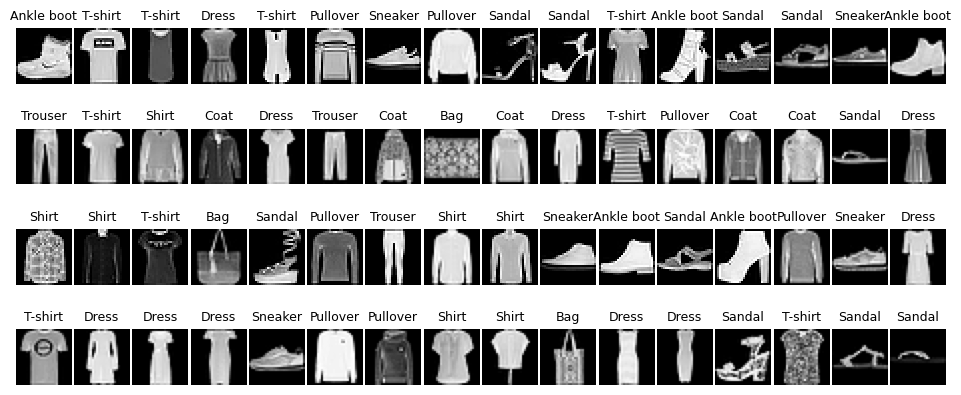

In [3]:
# 获得一个batch的数据
for step,(b_x,b_y) in enumerate(train_loader):
    if step > 0:
        break
    # 可视化一个batch的图像
    batch_x = b_x.squeeze().numpy()
    batch_y = b_y.numpy()
    class_label = train_data.classes
    class_label[0] = "T-shirt"
    plt.figure(figsize=(12,5))
    plt.subplots_adjust(wspace = 0.05)
    for ii in np.arange(len(batch_y)):
        plt.subplot(4,16,ii+1)
        plt.imshow(batch_x[ii,:,:],cmap=plt.cm.gray)
        plt.title(class_label[batch_y[ii]],size=9)
        plt.axis("off")
    

In [4]:
# 对测试集进行处理
test_data = FashionMNIST(
    root = "../data/FashionMNIST", # 数据的路径
    train = False,                 # 不使用训练数据
    download = False               # 因为数据已经下载过了，所以这里不再下载
)
# 为数据添加一个通道维度，并且取值范围缩放到0~1之间。
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = torch.unsqueeze(test_data_x,dim = 1)
test_data_y = test_data.targets # 测试集的标签
print("test_data_x.shape:",test_data_x.shape)
print("test_data_y.shape:",test_data_y.shape)

test_data_x.shape: torch.Size([10000, 1, 28, 28])
test_data_y.shape: torch.Size([10000])


In [5]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet,self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1   , # 输入的feature map
                out_channels = 16 , # 输出的feature map
                kernel_size =  3  , # 卷积核尺寸
                stride = 1        , # 卷积核步长
                padding = 1       , # 进行填充
            ), # 卷积后 (1*28*28) -> (16*28*28)
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size = 2,  # 平均值池化层,使用2*2
                stride = 2 ,      # 池化步长为2
            ), # 池化后: (16*28*28) -> (16*14*14)
        )
        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,0), # 卷积操作(16*14*14)->(32*12*12)
            nn.ReLU(),
            nn.AvgPool2d(2,2)       # 平均值池化(32*12*12)->(32*6*6)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*6*6,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    # 定义网络的前向传播路径
    def forward(self,x):    
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1) # 展平多维的卷积图层
        output = self.classifier(x)
        return output
# 输出网络结构
myconvnet = MyConvNet()
print(myconvnet)

MyConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [6]:
# 定义网络的训练过程函数
def train_model(model,traindataloader,train_rate,criterion,optimizer,num_epochs=25):
    '''
    model: 网络模型
    traindataloader: 训练数据集,会切分为训练集和验证集
    train_rate: 训练集batchsize百分比
    criterion: 损失函数
    optimizer: 优化方法
    num_epochs: 训练的次数
    '''
    # 计算训练时的batch数量
    batch_num = len(traindataloader)
    train_batch_num = round(batch_num * train_rate)
    # 复制模型的参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print("epoch {}/{}".format(epoch,num_epochs-1))
        print('-'*10)
        # 每个epoch有两个训练阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step,(b_x,b_y) in enumerate(traindataloader):
            if step < train_batch_num:
                model.train() # 设置模型为训练模式
                output = model(b_x)
                pre_lab = torch.argmax(output,1)
                loss = criterion(output,b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval() # 设置模型为评估模式
                output = model(b_x)
                pre_lab = torch.argmax(output,1)
                loss = criterion(output,b_y)
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data)
                val_num += b_x.size(0)
        # 计算一个epoch在训练集和验证机上的损失和精度
        train_loss_all.append(train_loss/train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num )
        print("{} train loss: {:.4f} train acc: {:.4f}".format(epoch,train_loss_all[-1],train_acc_all[-1]))
        print("{} val loss: {:.4f} val acc: {:.4f}".format(epoch,val_loss_all[-1],val_acc_all[-1]))
        # 拷贝模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print( "train and val complete in {:.0f}m {:.0f}s".format(time_use // 60, time_use % 60))
        
        # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data = {"epoch":range(num_epochs),
                "train_loss_all":train_loss_all,
                "val_loss_all":val_loss_all,
                "train_acc_all":train_acc_all,
                "val_acc_all":val_acc_all}
    )
    return model,train_process       

In [9]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvnet.parameters(),lr = 0.0003)
criterion = nn.CrossEntropyLoss() # 损失函数
myconvnet,train_process = train_model(myconvnet,train_loader,0.8,criterion,optimizer,num_epochs=25)

epoch 0/24
----------
0 train loss: 0.7832 train acc: 0.7104
0 val loss: 0.5510 val acc: 0.7867
train and val complete in 3m 21s
epoch 1/24
----------
1 train loss: 0.5051 train acc: 0.8112
1 val loss: 0.4687 val acc: 0.8282
train and val complete in 6m 50s
epoch 2/24
----------
2 train loss: 0.4381 train acc: 0.8393
2 val loss: 0.4257 val acc: 0.8429
train and val complete in 10m 13s
epoch 3/24
----------
3 train loss: 0.3981 train acc: 0.8541
3 val loss: 0.3960 val acc: 0.8552
train and val complete in 13m 42s
epoch 4/24
----------
4 train loss: 0.3691 train acc: 0.8642
4 val loss: 0.3718 val acc: 0.8662
train and val complete in 17m 17s
epoch 5/24
----------
5 train loss: 0.3466 train acc: 0.8729
5 val loss: 0.3560 val acc: 0.8723
train and val complete in 20m 38s
epoch 6/24
----------
6 train loss: 0.3291 train acc: 0.8781
6 val loss: 0.3428 val acc: 0.8765
train and val complete in 24m 2s
epoch 7/24
----------
7 train loss: 0.3147 train acc: 0.8833
7 val loss: 0.3329 val acc: 0.88

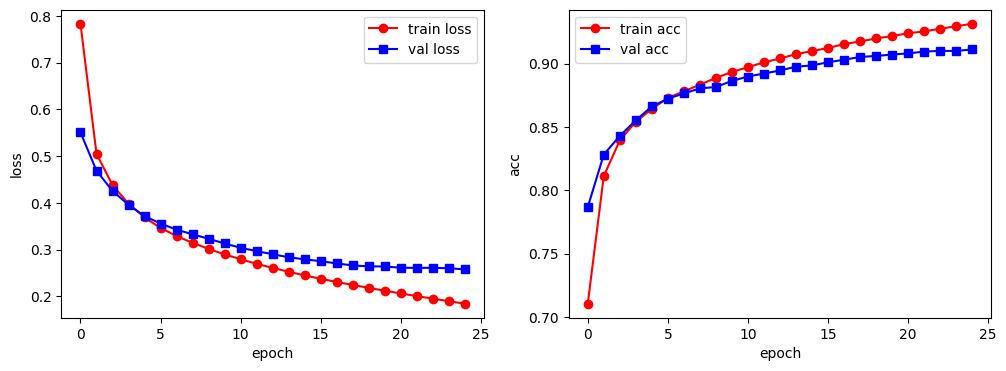

In [11]:
# 可视化模型训练过程
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,"ro-",label="train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,"bs-",label="val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,"ro-",label="train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,"bs-",label="val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [12]:
# 对测试集进行预测，并可视化预测结果
myconvnet .eval()
output  = myconvnet(test_data_x)
pre_lab = torch.argmax(output,1)
acc = accuracy_score(test_data_y,pre_lab)
print("在测试集上的预测精度为:",acc)

在测试集上的预测精度为: 0.9038


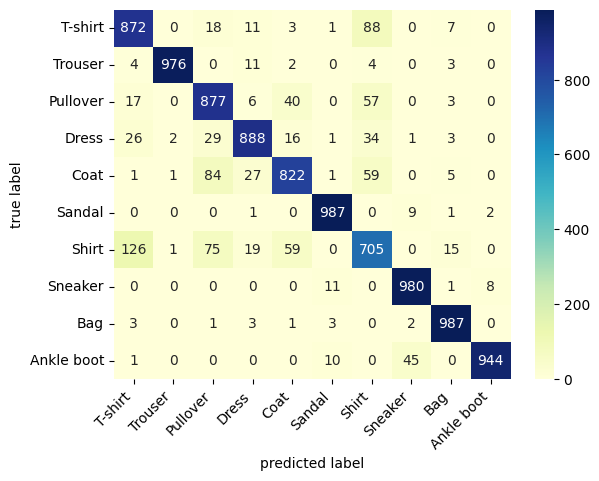

In [13]:
# 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_data_y,pre_lab)
df_cm = pd.DataFrame(conf_mat,index=class_label,columns = class_label)
heatmap = sns.heatmap(df_cm,annot=True,fmt="d",cmap = "YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha="right")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45,ha="right")
plt.ylabel("true label")
plt.xlabel("predicted label")
plt.show()

### code2-空洞卷积神经网络

In [14]:
class MyConvdilaNet(nn.Module):
    def __init__(self):
        super(MyConvdilaNet,self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,3,1,1,dilation=2), # (1,28,28) -> (16,26,26)
            nn.ReLU(),
            nn.AvgPool2d(2,2), # (16,26,26)->(16,13,13)
        )
        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,0,dilation=2), # (16,13,13) -> (32,9,9)
            nn.ReLU(),
            nn.AvgPool2d(2,2), # (32,9,9)->(32,4,4)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*4*4,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    # 定义网络的前向传播路径
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1) # 展平多维的卷积图层
        output = self.classifier(x)
        return output
        
# 输出网络结构
myconvdilanet = MyConvdilaNet()

In [15]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvdilanet.parameters(),lr = 0.0003)
criterion = nn.CrossEntropyLoss() # 损失函数
myconvdilanet,train_process = train_model(
    myconvdilanet,train_loader,0.8,criterion,optimizer,num_epochs = 25
)

epoch 0/24
----------
0 train loss: 0.9220 train acc: 0.6606
0 val loss: 0.6362 val acc: 0.7509
train and val complete in 0m 13s
epoch 1/24
----------
1 train loss: 0.6068 train acc: 0.7655
1 val loss: 0.5676 val acc: 0.7799
train and val complete in 0m 27s
epoch 2/24
----------
2 train loss: 0.5485 train acc: 0.7877
2 val loss: 0.5256 val acc: 0.8009
train and val complete in 0m 41s
epoch 3/24
----------
3 train loss: 0.5068 train acc: 0.8072
3 val loss: 0.4910 val acc: 0.8186
train and val complete in 0m 56s
epoch 4/24
----------
4 train loss: 0.4733 train acc: 0.8236
4 val loss: 0.4630 val acc: 0.8289
train and val complete in 1m 10s
epoch 5/24
----------
5 train loss: 0.4465 train acc: 0.8353
5 val loss: 0.4405 val acc: 0.8383
train and val complete in 1m 24s
epoch 6/24
----------
6 train loss: 0.4240 train acc: 0.8435
6 val loss: 0.4223 val acc: 0.8472
train and val complete in 1m 39s
epoch 7/24
----------
7 train loss: 0.4046 train acc: 0.8511
7 val loss: 0.4056 val acc: 0.8534
t

In [16]:
# 对测试集进行预测，并可视化预测结果
myconvnet .eval()
output  = myconvnet(test_data_x)
pre_lab = torch.argmax(output,1)
acc = accuracy_score(test_data_y,pre_lab)
print("在测试集上的预测精度为:",acc)

在测试集上的预测精度为: 0.9038


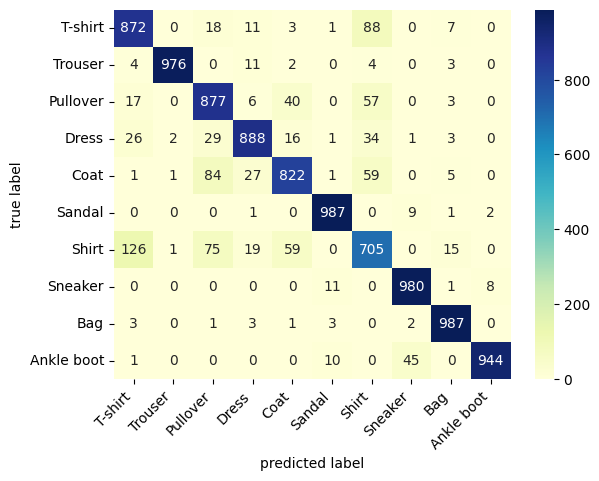

In [17]:
# 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_data_y,pre_lab)
df_cm = pd.DataFrame(conf_mat,index=class_label,columns = class_label)
heatmap = sns.heatmap(df_cm,annot=True,fmt="d",cmap = "YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha="right")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45,ha="right")
plt.ylabel("true label")
plt.xlabel("predicted label")
plt.show()

## VGG16分类模型微调

### 导入相关库

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl
import torch
import torch.nn as nn
from torch.optim import SGD,Adam
import torch.utils.data as Data
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

### 数据集

kaggle数据库中的10类猴子数据集:    
https://www.kaggle.com/datasets/slothkong/10-monkey-species   
- 训练数据集中每类月140张RGB图片。
- 验证数据集中每类约30张图像。

### code

In [40]:
# 导入预训练好的VGG16网络
vgg16 = models.vgg16(pretrained=True)
# 获取VGG16的特征提取层
vgg = vgg16.features
# 将vgg16的特征提取层参数冻结，不对其进行更新
for param in vgg.parameters():
    param.requires_grad_(False)

In [41]:
# 使用VGG16的特征提取层+新的全连接层组成新的网络
class MyVggModel(nn.Module):
    def __init__(self):
        super(MyVggModel,self).__init__()
        # 预训练的VGG16的特征提取层
        self.vgg = vgg
        # 添加新的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(25088,512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256,10),
            nn.Softmax(dim=1)
        )
    # 定义网络的前向传播路径
    def forward(self,x):
        x = self.vgg(x)
        x = x.view(x.size(0),-1)
        output = self.classifier(x)
        return output

In [42]:
# 输出网络结构
myvgg = MyVggModel()
print(myvgg)

MyVggModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [44]:
# 使用10类猴子的数据集，对训练集预处理
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # 随机长宽比裁剪为224x224
    transforms.RandomHorizontalFlip(), # 依概率p=0.5水平翻转
    transforms.ToTensor()   ,          # 转换为张量并归一化至[0-1]
    # 图形标准化处理
    transforms.Normalize([0.485,0.465,0.406],[0.229,0.224,0.225])
])
# 对验证集的预处理
val_data_transforms = transforms.Compose([
    transforms.Resize(256) ,    # 重置图像分辨率
    transforms.CenterCrop(224), # 根据给定的size从中间裁剪
    transforms.ToTensor()   ,   # 转换为张量并归一化至[0-1]
    # 图形标准化处理
    transforms.Normalize([0.485,0.465,0.406],[0.229,0.224,0.225])
])

In [45]:
# 读取训练集图像
train_data_dir = "../data/10-monkey-species/training"
train_data = ImageFolder(train_data_dir,transform=train_data_transforms)
train_data_loader = Data.DataLoader(train_data,batch_size=32,shuffle=True,num_workers=2)
# 读取验证集
val_data_dir = "../data/10-monkey-species/validation"
val_data = ImageFolder(val_data_dir ,transform=val_data_transforms)
val_data_loader = Data.DataLoader(val_data ,batch_size=32,shuffle=True,num_workers=2)
print("训练集样本数:",len(train_data.targets))
print("验证集样本数:",len(val_data.targets))


训练集样本数: 1097
验证集样本数: 272


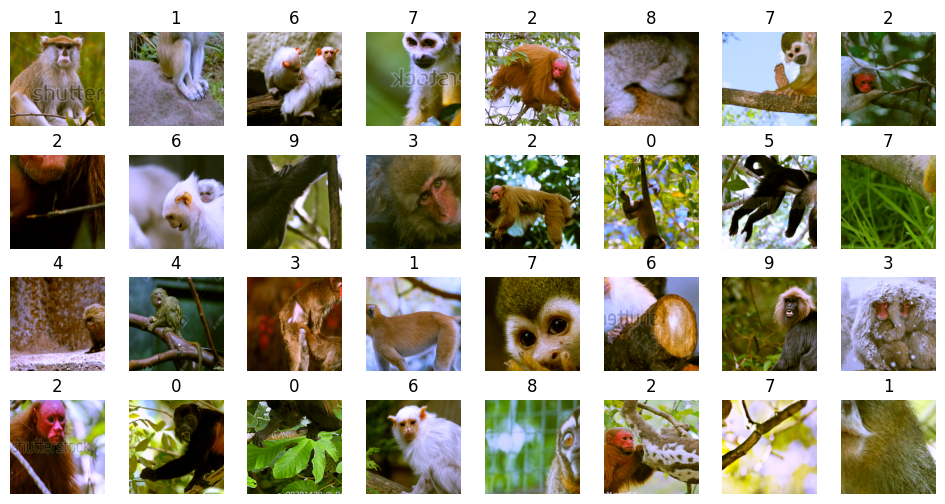

In [46]:
# 获取一个batch的数据
for step,(b_x,b_y) in enumerate(train_data_loader):
    if step > 0:   
        break
    # 可视化训练集其中一个batch的图像
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.406])
    plt.figure(figsize=(12,6))
    for ii in np.arange(len(b_y)):
        plt.subplot(4,8,ii+1)
        image = b_x[ii,:,:,:].numpy().transpose((1,2,0))
        image = std*image + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(b_y[ii].data.numpy())
        plt.axis("off")
    plt.subplots_adjust(hspace=0.3)

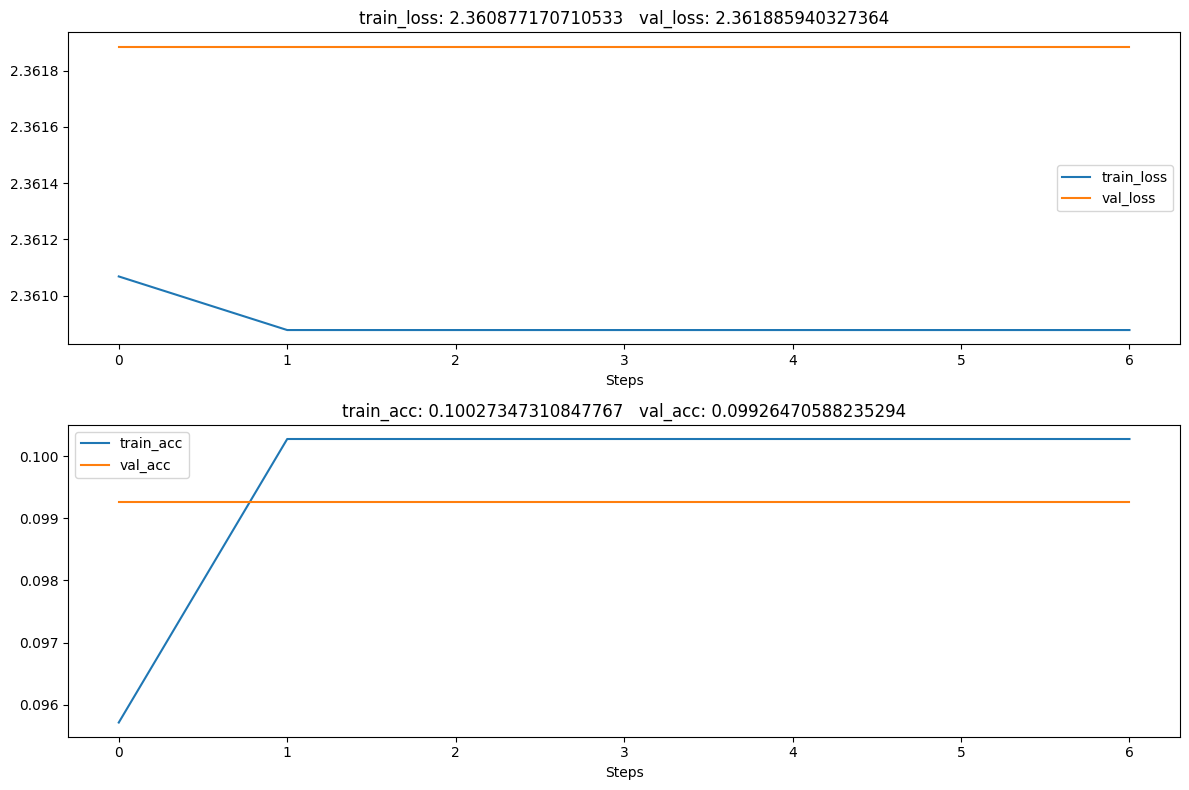

KeyboardInterrupt: 

In [47]:
# 定义优化器
optimizer = torch.optim.Adam(myvgg.parameters(),lr=0.003)
loss_func = nn.CrossEntropyLoss() # 损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
# 对模型进行迭代训练
for epoch in range(10):
    train_loss_epoch = 0
    val_loss_epoch = 0
    train_corrects = 0
    val_corrects = 0
    # 对训练数据的加载器进行迭代计算
    myvgg.train()
    for step,(b_x,b_y) in enumerate(train_data_loader):
        # 计算每个batch的损失
        output = myvgg(b_x)
        loss = loss_func(output,b_y)
        pre_lab = torch.argmax(output,1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * b_x.size(0)
        train_corrects += torch.sum(pre_lab == b_y.data)
    # 计算一个epoch的损失和精度
    train_loss = train_loss_epoch.double() / len(train_data.targets)
    train_acc = train_corrects.double() / len( train_data.targets)
    # 计算在验证集上的表现
    myvgg.eval()
    for step,(b_x,b_y) in enumerate(val_data_loader):
        # 计算每个batch的损失
        output = myvgg(b_x)
        loss = loss_func(output,b_y)
        pre_lab = torch.argmax(output,1)
        val_loss_epoch += loss.item() * b_x.size(0)
        val_corrects += torch.sum(pre_lab == b_y.data)
    # 计算一个epoch的损失和精度
    val_loss = val_loss_epoch.double() / len(val_data.targets)
    val_acc = val_corrects.double() / len( val_data.targets )
    # 保存每个epoch上的输出loss和acc
    history1.log(
        epoch,train_loss = train_loss,val_loss = val_loss,
        train_acc = train_acc.item(),
        val_acc = val_acc.item()
    )
    # 可视化网络训练过程
    with canvas1:
        canvas1.draw_plot([history1["train_loss"],history1["val_loss"]])
        canvas1.draw_plot([history1["train_acc"],history1["val_acc"]])

## 卷积神经网络情感分类

### 导入相关包

In [56]:
# 导入需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import seaborn as sns
from wordcloud import WordCloud
import time
import copy
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
# 版本兼容问题, torchtext 和 pytorch有版本兼容问题
# from torchtext import data
# from torchtext.vocab import Vectors,Glove

### 数据集

IMDB的电影评论数据集: https://gitcode.com/open-source-toolkit/7b474/blob/main/IMDB%E5%BD%B1%E8%AF%84%E6%95%B0%E6%8D%AE%E9%9B%86.rar  
该数据集共有5万条评论，其中25000条是训练数据，25000条是测试数据。   
每条评论都已明确标记为正面（好评）或负面（差评），基于10分制评分系统。   

### code

In [84]:
# 定义读取训练数据和测试数据的函数
def load_text_data(path):
    data = pd.read_csv(path,sep="\t")
    text_data = data["review"].to_numpy()
    label = data["sentiment"].to_numpy()
    return text_data,label 
def load_text_test_data(path):
    data = pd.read_csv(path,sep="\t")
    text_data = data["review"].to_numpy()
    id = data["id"].to_numpy()
    label = [ 1 if int(i.split("_")[-1]) > 5 else 0  for i in id ]
    return text_data,np.array(label)

In [89]:
train_path = "../data/imdb/labeledTrainData.tsv"
test_path = "../data/imdb/testData.tsv"
train_text,train_label = load_text_data(train_path)
test_text,test_label = load_text_test_data(test_path)
print(len(train_text),len(train_label))
print(len(test_text),len(test_label))
print(test_label)

25000 25000
25000 25000
[1 0 0 ... 0 1 1]


In [86]:
# 对文本数据进行预处理
def text_preprocess(text_data):
    text_pre = []
    for text1 in text_data:
        # 去除指定的字符<br/><br/>
        text1 = re.sub("<br /> <br />"," ",text1)
        # 转换为小写，去除数字，去除标点符号，去除空格
        text1 = text1.lower()
        text1 = re.sub("\d+","",text1)
        text1 = text1.translate(
            str.maketrans("","",string.punctuation.replace("'",""))
        )
        text1 = text1.strip()
        text_pre.append(text1)
    return np.array(text_pre)
train_text_pre = text_preprocess(train_text)
test_text_pre = text_preprocess(test_text)
print(train_text_pre[0])
print("="*10)
print(test_text_pre[0])

with all this stuff going down at the moment with mj i've started listening to his music watching the odd documentary here and there watched the wiz and watched moonwalker again maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent moonwalker is part biography part feature film which i remember going to see at the cinema when it was originally released some of it has subtle messages about mj's feeling towards the press and also the obvious message of drugs are bad m'kaybr br visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of himbr br the actual feature film bit when it finally starts is only on for  mi

In [75]:
# 文本符号化处理，去除停用词
def stop_stem_word( datalist,stop_words):
    datalist_pre = []
    for text in datalist:
        text_words = word_tokenize(text)
        # 去除停用词
        text_words = [word for word in text_words if not word in stop_words]
        # 删除带有"'"的词语，比如: it's
        text_words = [word for word in text_words if len(re.findall("'",word))==0]
        datalist_pre.append(text_words)
    return datalist_pre

In [87]:
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = stopwords.words("english")
stop_words = set(stop_words)
train_text_pre2 = stop_stem_word(train_text_pre,stop_words)
test_text_pre2 = stop_stem_word(test_text_pre,stop_words)
print(train_text_pre[10000])
print("="*10)
print(train_text_pre2[10000])
print("*"*10)
print(test_text_pre[10000])
print("="*10)
print(test_text_pre2[10000])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wkk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wkk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


i would have rated the series a perfect  for outstanding and consistently high quality story and character development had it not been for the last episode of season  br br the final episode of the th season unending where it would certainly appear that the asgard have been killedoff in a very rushed unconvincing and very unceremonious fashion left me in disbelief br br from the extremely rushed end of the series it's obvious that many of the story arcs were originally scheduled to occur over at least one more season my guess would be that they rapidly accelerated these stories to position the stargate sg franchise for the two upcoming directtodvd movesbr br unless the asgard return in a future sg movie with a very good explanation of the apparent extinction i think that the fans have been cheated with a poor cleanup of looseendsbr br poor end to an otherwise brilliant scifi series
['would', 'rated', 'series', 'perfect', 'outstanding', 'consistently', 'high', 'quality', 'story', 'chara

In [80]:
# 将处理好的文本保存到CSV文件中
texts = [" ".join(words) for words in train_text_pre2]
traindatasave = pd.DataFrame({
    "text": texts,
    "label": train_label
})
traindatasave.to_csv("../data/imdb/train_csv",index=False)

In [90]:
# 将处理好的文本保存到CSV文件中
texts = [" ".join(words) for words in test_text_pre2]
testdatasave = pd.DataFrame({
    "text": texts,
    "label": test_label
})
testdatasave.to_csv("../data/imdb/test_csv",index=False)

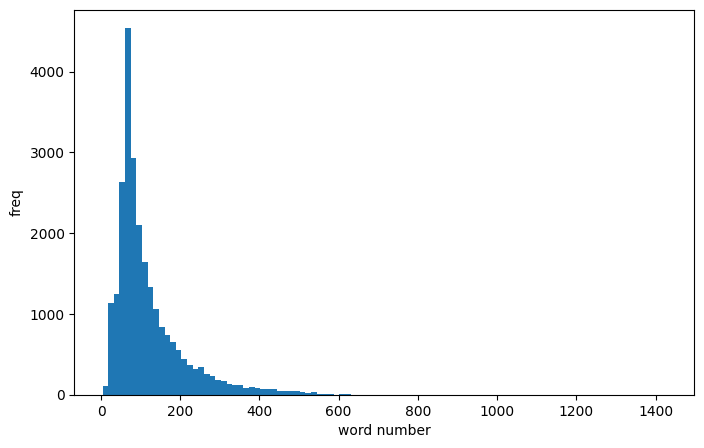

In [91]:
# 将预处理好的文本数据转换为数据表
traindata = pd.DataFrame({
    "train_text":train_text,
    "train_word":train_text_pre2,
    "train_label":train_label
})
# 计算每个影评使用词的数量
train_word_num = [len(text) for text in train_text_pre2]
traindata["train_word_num"] = train_word_num
# 可视化影评词语长度的分布
plt.figure(figsize=(8,5))
_=plt.hist(train_word_num,bins=100)
plt.xlabel("word number")
plt.ylabel("freq")
plt.show()

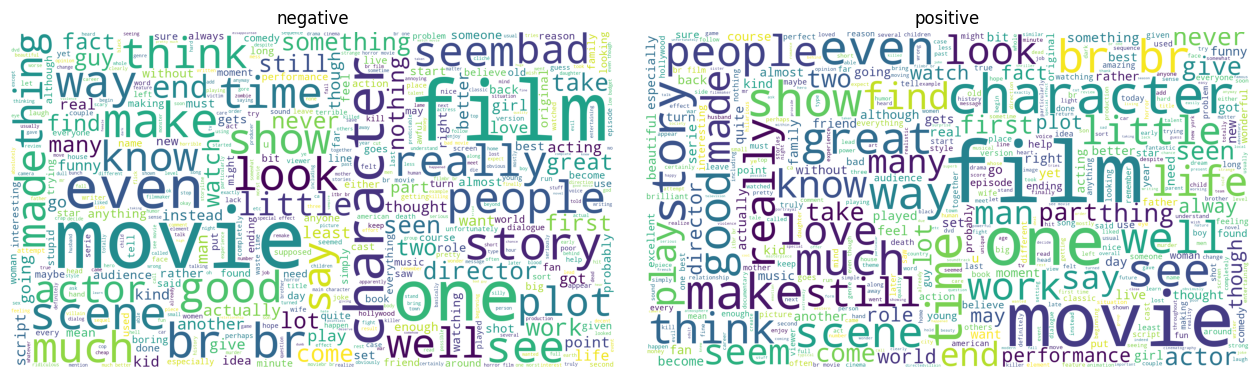

In [94]:
# 使用词云可视化两种情感的词频差异
plt.figure(figsize=(16,10))
for ii in np.unique(train_label):
    # 准备每种情感的所有词语
    text = np.array(traindata.train_word[traindata.train_label == ii])
    text = " ".join(np.concatenate(text))
    plt.subplot(1,2,ii+1)
    # 生成词云
    wordcod = WordCloud(margin=5,width = 1800, height = 1000,
                max_words = 500, min_font_size = 5,
                background_color = "white",
                max_font_size = 250)
    wordcod.generate_from_text(text)
    plt.imshow(wordcod)
    plt.axis("off")
    if ii == 1:
        plt.title("positive")
    else:
        plt.title("negative")
    plt.subplots_adjust(wspace = 0.05)
plt.show()

In [95]:
# 使用torchtext库进行数据准备，定义文件中和标签所要做的操作。
# 定义文本切分方法，因为前面已经做过处理了，所以直接使用空格切分即可。
mytokenize = lambda x: x.split()
TEXT = data.Field(
    sequential = True, takenize=mytokenize,
    include_lengths = True, use_vocab = True,
    batch_first = True, fix_length = 200
)
LABEL = data.Field(
    sequential = False, use_vocab = False, 
    pad_token = None, unk_token = None
)
# 对所要读取的数据集的列进行处理
train_test_fields = [
    ("label",LABEL), # 对标签的操作
    ("text", TEXT)   # 对文本的操作
]
# 读取数据
traindata,testdata = data.TabularDataset.splits(
    path="../data/imdb", format = "csv",
    train = "train.csv", fields = train_test_field,
    test = "test.csv", skip_header = True
)
print("train len:", len(traindata))
print("test_len:", len(testdata))

NameError: name 'data' is not defined

In [ ]:
# 使用examples方法获取数据集中的样本
ex0 = traindata.examples[0]
print(ex0.label)
print(ex0.text)

In [ ]:
# 训练集切分为训练集和测试集
train_data,val_data = traindata.split(split_ratio = 0.7)
print("训练集 len:", len(train_data))
print("验证集 len:", len(val_data))

词向量： https://gitcode.com/open-source-toolkit/fd914/overview?utm_source=tools_gitcode&index=top&type=card&&isLogin=1

In [ ]:
# 加载预训练的词向量和构建词汇表
vec = Vectors("glove.6B.100d.txt","../data")
# 将训练集转化为词向量，使用训练集构建单词表，导入预先训练的词嵌入
TEXT.build_vocab(train_data,max_size = 20000,vectors = vec)
LABEL.build_vocab(train_data)
# 训练集中的前10个高频词
print(TEXT.vocab.freqs.most_common(n=10))
print("词典的词数:",len(TEXT.vocab.itos))
print("前10个单词:\n",TEXT.vocab.itos[0:10])
# 类别标签的数量和类别
print("类别标签情况:",LABEL.vocab.freqs)

In [ ]:
# 定义一个加载器，将类似长度的示例一起批处理
BATCH_SIZE = 32
train_iter = data.BucketIterator(train_data,batch_size = BATCH_SIZE)
val_iter = data.BucketIterator(val_data,batch_size = BATCH_SIZE)
test_iter = data.BucketIterator(testdata,batch_size = BATCH_SIZE)
# 获得一个batch的数据，对数据内容进行介绍
for step, batch in enumerate(train_iter):
    if step > 0:
        break
    # 针对一个batch的数据，可以使用batch.label获得数据的类别标签
    print("数据的类别标签:\n", batch.label)
    # batch.text[0]是文本对应的标签向量
    print("数据的尺寸:",batch.text[0].shape)
    # batch.text[1], 对应每个batch使用的原始数据中的索引
    print("数据样本数:",len(batch.text[1]))

In [ ]:
class CNN_Text(nn.Module):
    def __init__(self,vocab_size, embedding_dim, n_filters,filter_sizes,output_dim,
                dropout,pad_idx):
        super().__init__()
        '''
            vocab_size: 词典大小；embedding_dim: 词向量的维度
            n_filters: 卷积核的数量， filter_sizes: 卷积核的尺寸
            output_dim: 输出的维度, droput: dropout的比率
            pad_idx: 填充的索引
        '''
        # 对文本进行词嵌入操作
        self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx = pad_idx)
        # 卷积操作
        self.convs = nn.ModuleList([
            nn.Conv2d( in_channels = 1, output_channels = n_filters,
                       kernel_size = (fs,embedding_dim)) 
            for fs in filter_sizes
        ])
        # 全连接层和Dropout层
        self.fc = nn.Linear( len(filter_sizes ) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward( self,text):
        # text = [batch size,sent len]
        embedded = self.embedding(text)
        # embeded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        # embedded [ batch size, 1, sent len , emb dim]
        conved = [ F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved_n = [ batch size, n_filters , sent len - filter_sizes[n] + 1
        pooled = [ F.max_pool1d(conv,conv.shape[2]).squeeze(2) for conv in conved ]
        # pooled_n = [ batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        # cat = [ batch size, n_filters * len( filter_sizes)]
        return self.fc(cat)  

In [ ]:
INPUT_DIM = len(TEXT.vocab) # 词典的数量
EMBEDDING_DIM = 100         # 词向量的维度
N_FILTERS = 100             # 每个卷积核的个数
FILTER_SIZES = [3,4,5]     # 卷积核的大小
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # 填充词的索引
model = CNN_TEXT(INPUT_DIM, EMBEDDING_DIM, N_FILTERS,FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
print( model)

In [ ]:
# 将导入的词向量作为embedding.weight的初始值
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
# 将无法识别的词<unk>, <pad> 的向量初始化为0
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model.embedding.weight.data[UNK_IDX] torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX ] torch.zeros(EMBEDDING_DIM)

In [ ]:
# 定义一个对数据集训练一轮的函数
def train_epoch( model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    train_corrects = 0
    train_num = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        pre = model( batch.text[0]).squeeze(1)
        loss = criterion(pre, batch.label.type(torch.FloatTensor))
        pre_lab = torch.round( torch.sigmoid(pre) )
        train_corrects += torch.sum( pre_lab.long() == batch.label)
        train_num += len( batch.label) # 样本数量
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # 所有样本的平均损失和精度
    epoch_loss = epoch_loss / train_num
    epoch_acc = train_corrects.double().item() / train_num 
    return epoch_loss, epoch_acc
# 定义一个对数据集验证一轮的函数
def evaluate( model,iterator, criterion ):
    epoch_loss = 0
    epoch_acc = 0
    train_corrects = 0
    train_num = 0
    model.eval()
    with torch.no_grad(): # 禁止梯度计算
        for batch in iterator:
            pre = model( batch.text[0]).squeeze(1)
            loss = criterion(pre,batch.label.type( torch.FloatTensor ))
            pre_lab = torch.round( torch.sigmoid( pre )) 
            train_corrects += torch.sum( pre_lab.long() == batch.label )
            train_num += len( batch.label) # 样本数量
            epoch_loss += loss.item()
        # 所有样本的平均损失和精度
        epoch_loss = epoch_loss / train_num 
        epoch_acc = train_corrects.double().item() / train_num 
    return epoch_loss, epoch_acc

In [ ]:
# 使用训练集训练模型，使用验证集测试模型
EPOCHS = 10
best_val_loss = float("inf")
best_acc = float(0)
for epoch in range( EPOCHS ):
    start_time = time.time()
    train_loss,train_acc = train_epoch(model,train_iter,optimizer.criterion)
    val_loss , val_acc = evaluate(model,val_iter,criterion)
    end_time = time.time()
    print("epoch:",epoch+1,"|","epoch time:",end_time-start_time,"s")
    print("train loss:",train_loss,"|","train acc:",train_acc)
    print("val loss:", val_loss,"|", "val acc:", val_acc)
    # 保存效果较好的模型
    if( val_loss < best_val_loss) & ( val_acc > best_acc )
        best_model_wts = copy.deepcopy( model.state_dict())
        best_val_loss = val_loss
        best_acc = val_acc 
 # 将最好模型的参数重新赋值给model
 model.load_state_dict( best_model_wts)

In [ ]:
# 使用evaluate函数对测试集进行预测
test_loss, test_acc = evaluate( model, test_iter,criterion )
print( "测试集上的预测精度为: ", test_acc)

## 使用预训练好的卷积网络

### 导入相关库

In [1]:
# 导入所需要的库和模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image